In [537]:
import sys
import math
import string
import operator
import random
import collections
import datetime
import itertools
import functools

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import IPython
import sympy as sp
import sympy.core.random as spr
import sympy.plotting as splt
import sympy.physics.vector as spv
import sympy.physics.mechanics as spm
import scipy.constants as spc

import IPython.display as ipd
spv.init_vprinting()
%matplotlib inline

HALF = sp.S.Half
PI = sp.pi
E = sp.exp
POSITIVEINFINITY = sp.S.Infinity


def reference_frame(
    frame: str,
    x=r'\imath', y=r'\jmath', z=r'\mathbf k'
) -> spv.ReferenceFrame:
    return spv.ReferenceFrame(
        frame, latexs=(
            fr'\; {{}}^\mathcal {frame} \hat {x}',
            fr'\;{{}}^\mathcal {frame} \hat {y}',
            fr'\: {{}}^\mathcal {frame} \hat {{z}}'
        )
    )


def RAOreference_frame(
    frame: str,
    x=r'E_1', y='E_2', z=r'E_3'
) -> spv.ReferenceFrame:
    return spv.ReferenceFrame(
        frame, latexs=(
            fr'\; {{}}^{frame} \hat {x}',
            fr'\;{{}}^{frame} \hat {y}',
            fr'\: {{}}^{frame} \hat {z}'
        )
    )


def vector(F: spv.ReferenceFrame, rx, ry, rz=0) -> spv.Vector:
    return rx*F.x + ry*F.y + rz*F.z


def vector_cos(
    F: spv.ReferenceFrame, magnitude,
    anglex, angley, anglez=sp.pi/2
) -> spv.Vector:
    return (magnitude *
            (sp.cos(anglex)*F.x
             + sp.cos(angley)*F.y
             + sp.cos(anglez)*F.z
             )
            )


def vector_line(
    start: spv.Vector, finish: spv.Vector
) -> spv.Vector:
    return finish - start


def vector_line_eqn(
    F: spv.ReferenceFrame, start: spv.Vector, finish: spv.Vector, kappa
) -> spv.Vector:
    return start + vector_line(start, finish).normalize()*kappa


def angle_between_vectors(a: spv.Vector, b: spv.Vector):
    return sp.acos(a.dot(b)/a.magnitude()/b.magnitude())


def print_aligned_latex_equations(*args):
    result = r'\\'.join([
        r'\begin{equation}',
        r'\begin{split}',
        *args,
        r'\nonumber',
        r'\end{split}',
        r'\end{equation}'
    ])

    ipd.display(ipd.Math( rf'{result}'))

__Mr Hart Tweet__

![](./images/MrHartTweet.png)

In [538]:
a, b, hx, hy, g = sp.symbols("a, b, h_x, h_y, g", real=True, positive=True)
values = {g:9.8, a:sp.Float(52.5), b:sp.Float(50), hy:10}
values

## One frame solution 

__Kinematics__

In [539]:
t, t_max_height, tf, t_para = sp.symbols(
    r't , t_mh, t_f, t_\parallel', 
    real=True, negative=False
)

vix, viy = sp.symbols("v_ix, v_iy", real=True)
rf = sp.Matrix([b, -a, 0])
r_max_height = sp.Matrix([hx, hy, 0])

v = sp.Matrix([vix, viy - g*t, 0])
r = sp.Matrix([vix*t, viy*t - HALF*g*t**2, 0])

assert (r.diff(t) - v == sp.zeros(3,1))

t, t_max_height, tf, t_para

In [540]:
eqn1 = sp.Eq(v.subs(t, t_max_height), sp.Matrix([vix, 0, 0]))
eqn2 = sp.Eq(r.subs(t, t_max_height), r_max_height)
eqn3 = sp.Eq(rf, r.subs(t, tf).subs(values))

eqn4 = sp.Eq(
    rf.normalized().subs(values), 
    v.normalized().subs(values).subs(t, t_para)
)

eqn1, eqn2, eqn3, eqn4

⎛                                                                             
⎜                                                                             
⎜                         ⎡      tₘₕ⋅vᵢₓ      ⎤                               
⎜                         ⎢                   ⎥                 ⎡       t_f⋅vᵢ
⎜⎡     vᵢₓ     ⎤   ⎡vᵢₓ⎤  ⎢       2           ⎥   ⎡hₓ ⎤  ⎡b ⎤   ⎢             
⎜⎢             ⎥   ⎢   ⎥  ⎢  g⋅tₘₕ            ⎥   ⎢   ⎥  ⎢  ⎥   ⎢         2   
⎜⎢-g⋅tₘₕ + v_iy⎥ = ⎢ 0 ⎥, ⎢- ────── + tₘₕ⋅v_iy⎥ = ⎢h_y⎥, ⎢-a⎥ = ⎢- 4.9⋅t_f  + 
⎜⎢             ⎥   ⎢   ⎥  ⎢    2              ⎥   ⎢   ⎥  ⎢  ⎥   ⎢             
⎜⎣      0      ⎦   ⎣ 0 ⎦  ⎢                   ⎥   ⎣ 0 ⎦  ⎣0 ⎦   ⎣          0  
⎜                         ⎣         0         ⎦                               
⎜                                                                             
⎜                                                                             
⎝                                                   

In [541]:
result = sp.solve(
    [eqn1.subs(values), 
     eqn2.subs(values), 
     eqn3.subs(values), 
     eqn4.subs(values)],
    dict=True
)[0]
result.update(values)
result

In [542]:
speed = sp.sqrt(result[vix]**2 + result[viy]**2).evalf(4)

print_aligned_latex_equations(rf"""
    \textrm{{Initial vertical projection velocity}} \quad
        &{spv.vlatex(result[viy])}\\
    \textrm{{projection speed}} \quad
        &{spv.vlatex(speed)}\\
    \textrm{{time parallel to OB}} \quad
        &{spv.vlatex(result[t_para])}\\
""" )

<IPython.core.display.Math object>

In [543]:
plt.style.use('seaborn')

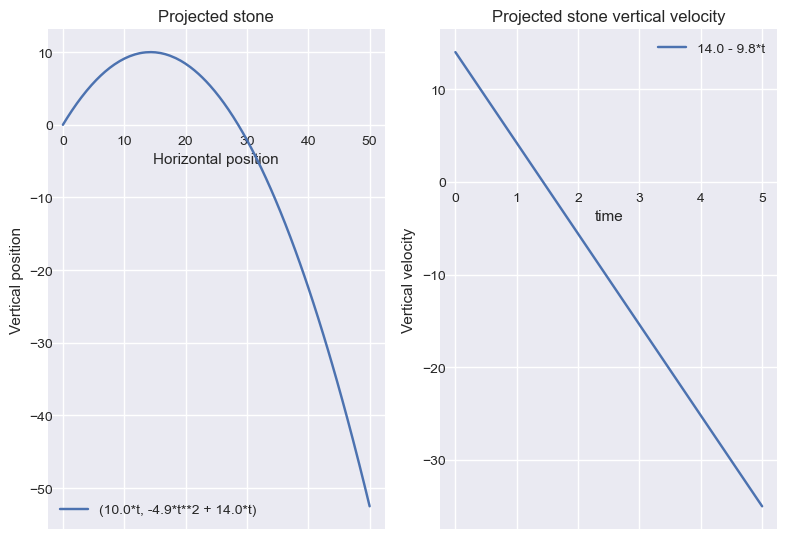

In [544]:
plot1 = splt.plot_parametric(
    (r[0].subs(result), r[1].subs(result)), 
    (t,0,5),
    size=(6, 5),
    show=False
)

plot1.line_color="Red"
plot1.title = "Projected stone"
plot1.legend = True
plot1.label = "Vertical position"
plot1.xlabel ="Horizontal position"
plot1.ylabel ="Vertical position"


plot2 = splt.plot(
    v[1].subs(result), 
    (t,0,5),
    size=(8, 5),
    show=False
)

plot2.title = "Projected stone vertical velocity"
plot2.legend = True
plot2.label = "Vertical velocity"
plot2.xlabel ="time"
plot2.ylabel ="Vertical velocity"
plot2.line_color="Red"

splt.PlotGrid(1, 2, plot1, plot2);
